### Environment Setup

In [ ]:

# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import scanpy as sc
import liana as li
import decoupler as dc

import session_info



In [ ]:
# R dependencies
import anndata2ri  # conversion
import rpy2
from rpy2.robjects import r  # running R in python
import random

anndata2ri.activate() 

%load_ext rpy2.ipython

In [ ]:
# import cellphonedb method via liana
from liana.method import cellphonedb

In [ ]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})

In [ ]:
# figure settings
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200, facecolor="white")
sc.set_figure_params(figsize=(5, 5))




### Upload data

In [ ]:
# Read Object
r('obj = readRDS("MERGED_NEW_ANNOTATION.rds")')

# convert Seurat to SCE
adata = r('Seurat::as.SingleCellExperiment(obj)')



## Manual Annotation

### Analysis


In [ ]:
adata.obs["merged_idents"].cat.categories

In [ ]:
sc.pl.umap(adata, color = ['Condition', 'merged_idents'], frameon = False)



#### Ligand-receptor inference

In [ ]:
adata_ss = adata[adata.obs["Condition"] == "ss"].copy()
adata_ss

In [ ]:
cellphonedb(
    adata_ss, groupby="merged_idents", use_raw=False, return_all_lrs=True, verbose=True
)

In [ ]:
data = adata_ss.uns["liana_res"]
data = data.sort_values('lr_means', ascending=False)
data['interaction'] = data['ligand_complex'] + '-' + data['receptor_complex']
data.head()


In [ ]:
top_interations = data['interaction'].unique()[0:30]
list(top_interations)

In [ ]:
adata_ss_filter = data.query("cellphone_pvals <= 0.01")

adata_ss_filter[0:30]



In [ ]:
lig_com = list(adata_ss_filter['ligand_complex'])
rec_comp = list(adata_ss_filter['receptor_complex'])

In [ ]:
cell_types = ['NK', 'B cells', 'CD8', 'CD4', 'Mono-Mac', 'Platelets', 'Granulocytes', 'Erythrocytes', 'Endothelial cells', 'DC', 'Epithilial cells']



#### Visual Exploration

In [ ]:
li.pl.dotplot(
    adata = adata_ss, 
    colour = 'lr_means',
    size = 'cellphone_pvals',
    inverse_size= True, 
    source_labels= cell_types, 
    target_labels= cell_types,
    ligand_complex= lig_com,
    receptor_complex= rec_comp, 
    orderby='lr_means',
    orderby_ascending= False, 
    top_n= 30, 
    figure_size=(25, 11),
    size_range=(1, 10)
)

In [ ]:
# See how much cell types appear in source
counts_source = []
counts_target = []
for cell in cell_types:
    count_s = adata_ss_filter['source'].value_counts()[cell]
    count_t = adata_ss_filter['target'].value_counts()[cell]
    counts_source.append(count_s)
    counts_target.append(count_t)

# Built a dataframe with the information
cells = pd.DataFrame([cell_types, counts_source, counts_target]).T
cells.columns = ['Cell Type', 'Source', 'Target']
cells = cells.sort_values('Source', ascending=False)

# Column with the difference between Source and Target
cells['Diff'] = cells['Source']  - cells['Target']
cells

In [ ]:
# Bar plot with the counts for each cell type both in Source and Target
cells.plot.bar(x='Cell Type', y=['Source', 'Target'])
plt.title('Source vs Target')
plt.xticks(rotation=30, ha='right', fontsize=10)

In [ ]:
# Plot the difference in counts of Source and Target for each cell type
cells2 = cells.sort_values('Diff', ascending=False)
cells2.plot.bar(x = 'Cell Type', y = 'Diff')
plt.xticks(rotation=30, ha='right', fontsize=10)


In [ ]:
# Loli-pop plot 
my_range=range(0,len(cells.index))

plt.stem(cells2['Diff'])
plt.xticks( my_range, cells2['Cell Type'])
plt.xticks(rotation=30, ha='right', fontsize=10)


In [ ]:
# Get the gene expression for all markers
markers = pd.read_table('Markers.csv', sep = ' ')
markers.head()

In [ ]:
# Get a table with the expression of the 30 top ligands
ligands = list(adata_ss_filter['ligand'])
mask= markers['gene'].isin(ligands[0:500])
markers_filter = markers[mask]
#markers_filter['avg_log2FC'] = abs(markers_filter['avg_log2FC'])
markers_filter

In [ ]:
# Create a matriz with the expression (avg_log2FC) of a gene in all cell types
matrix = markers_filter.pivot(index='gene', columns='cluster', values='avg_log2FC')
matrix.shape

In [ ]:
# Heatmap showing the different expression of ligands between cell types
heatmap = sns.heatmap(matrix, cmap = 'vlag')

In [ ]:
# Clustermap
sns.set(font_scale=1.2)
sns.set_style(style = 'darkgrid')
clustermap = sns.clustermap(matrix.fillna(0), cmap = 'vlag', annot = False, linewidths=.5, cbar_kws={"shrink": 0.7}  )
clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=12)
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=12)

In [ ]:
# Get a table with the top receptors expression 
receptors = list(adata_ss_filter['receptor'])
mask_re = markers['gene'].isin(receptors[0:500])
markers_filter_re = markers[mask_re]
# Matrix with receptors expression by cell type
matrix_re = markers_filter_re.pivot(index='gene', columns='cluster', values='avg_log2FC')
matrix_re.shape

In [ ]:
# Clustermap showing the expression of receptors by cell type
sns.set(font_scale=1.2)
clustermap_re = sns.clustermap(matrix_re.fillna(0), cmap = 'vlag', annot = False, linewidths=.5, cbar_kws={"shrink": 0.7}  )
clustermap_re.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=12)
clustermap_re.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=12)

In [ ]:
# Define cell types as sources or targets
sources_ma = ['B cells', 'Mono-Mac', 'DC', 'Epithilial cells']
targets_ma= ['B cells', 'CD8', 'CD4', 'NK']

In [ ]:
# Final dotplot with cell types divided in source and target

li.pl.dotplot(
    adata=adata_ss,
    colour='lr_means',
    size='cellphone_pvals',
    inverse_size=True,
    source_labels=sources_ma,
    target_labels=targets_ma,
    ligand_complex=lig_com,
    receptor_complex=rec_comp,
    orderby='lr_means',
    orderby_ascending=False,
    top_n=30,
    figure_size=(14, 12),
    size_range=(1, 10)
)




## Supervised Annotation

### Analysis

In [ ]:
adata.obs["majority_voting"].cat.categories

C:\Users\beatr\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
C:\Users\beatr\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


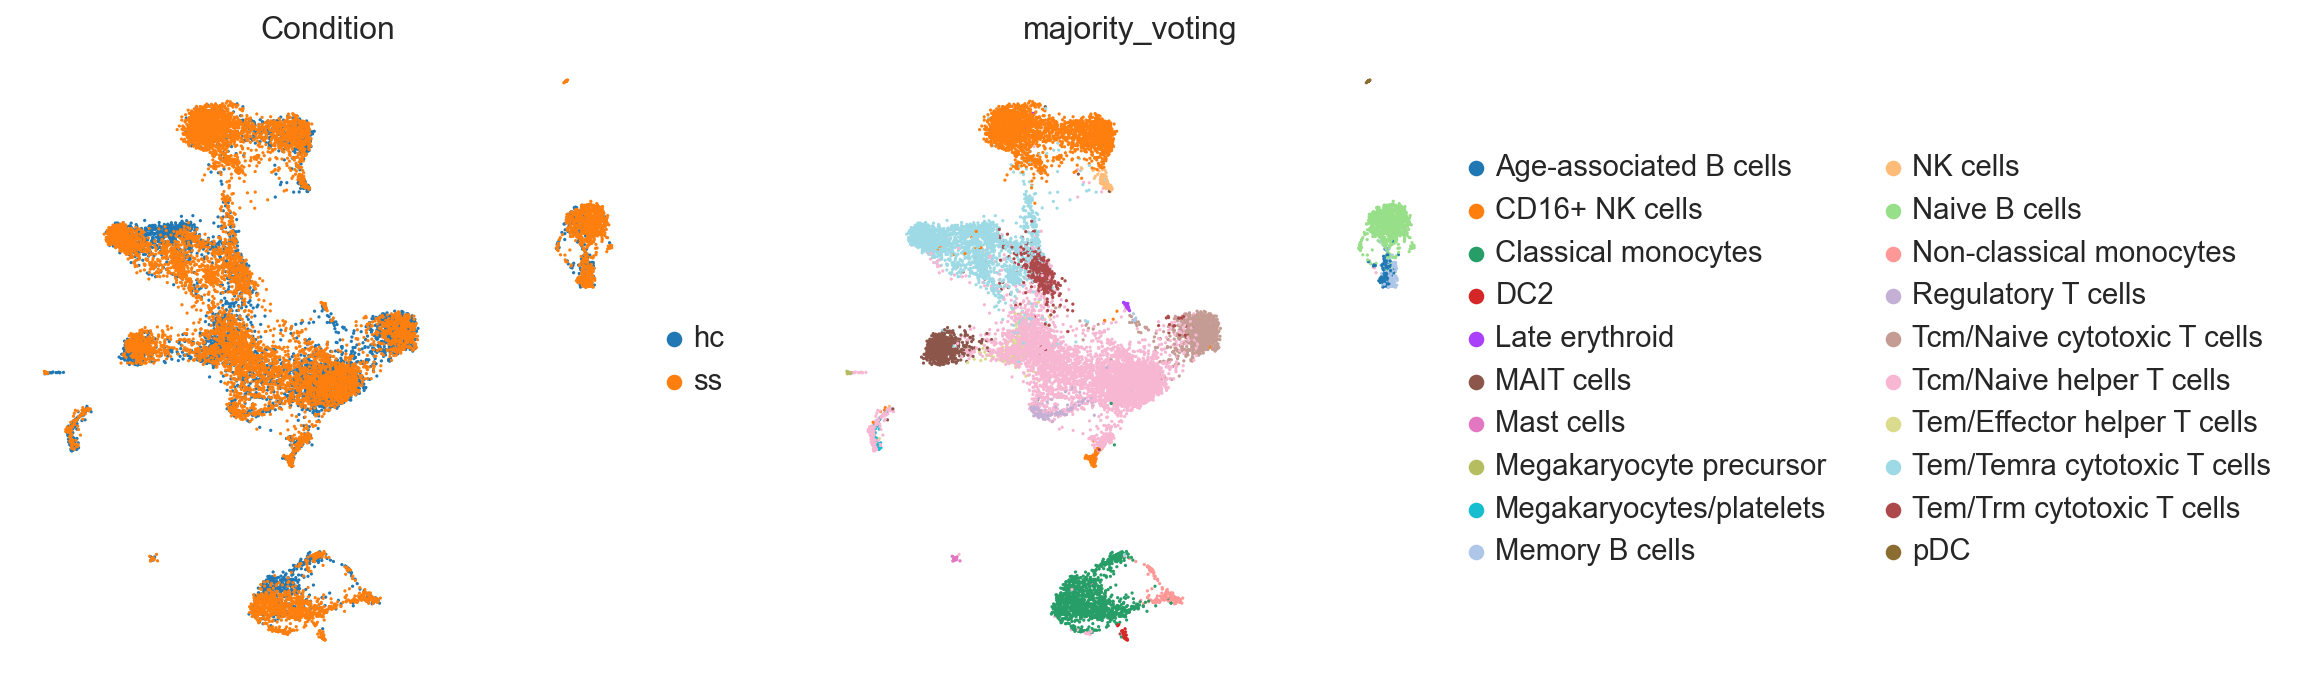

In [40]:
sc.pl.umap(adata, color=['Condition', 'majority_voting'], frameon=False)

#### Ligand - receptor inference

In [41]:
adata_ss = adata[adata.obs["Condition"] == "ss"].copy()
adata_ss

AnnData object with n_obs × n_vars = 9318 × 71823
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'iscell_dd', 'iscell_ed', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'Ident', 'Condition', 'unintegrated_clusters', 'RNA_snn_res.1', 'merged_idents', 'predicted_labels', 'over_clustering', 'majority_voting', 'ident'
    uns: 'Condition_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'UMAP.UNINTEGRATED', 'INTEGRATED.CCA', 'X_umap'
    layers: 'logcounts'

In [42]:
cellphonedb(
    adata_ss, groupby="majority_voting", use_raw=False, return_all_lrs=True, verbose=True
)

Using `.X`!
C:\Users\beatr\anaconda3\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
48859 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!
C:\Users\beatr\anaconda3\lib\site-packages\liana\method\_pipe_utils\_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
Using resource `consensus`.
0.29 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 9318 samples and 22964 features


100%|██████████| 1000/1000 [00:11<00:00, 87.53it/s]


In [43]:
data = adata_ss.uns["liana_res"]
data['interaction'] = data['ligand_complex'] + '-' + data['receptor_complex']
data.head()

ligand ligand_complex  ligand_means  ligand_props receptor  \
182375    APP            APP      6.833655      1.000000     CD74   
158165    APP            APP      0.888889      0.555556     CD74   
146061   COPA           COPA      0.814815      0.518519     CD74   
155744    APP            APP      0.736842      0.421053     CD74   
182376   COPA           COPA      0.722222      0.444444     CD74   

       receptor_complex  receptor_means  receptor_props  \
182375             CD74      264.222229             1.0   
158165             CD74      264.222229             1.0   
146061             CD74      264.222229             1.0   
155744             CD74      264.222229             1.0   
182376             CD74      264.222229             1.0   

                          source target  lrs_to_keep    lr_means  \
182375                       pDC    DC2         True  135.527939   
158165  Megakaryocytes/platelets    DC2         True  132.555557   
146061                       DC2    DC2         True  132.518524   
155744   Megakaryocyte precursor    DC2         True  132.479538   
182376                       pDC    DC2         True  132.472229   

        cellphone_pvals interaction  
182375              0.0    APP-CD74  
158165              0.0    APP-CD74  
146061              0.0   COPA-CD74  
155744              0.0    APP-CD74  
182376              0.0   COPA-CD74

In [44]:
# Filter by pvalue
adata_ss_filter_sa = data.query("cellphone_pvals <= 0.01")
adata_ss_filter_sa = adata_ss_filter_sa.sort_values('lr_means')
adata_ss_filter_sa.head()

ligand ligand_complex  ligand_means  ligand_props receptor  \
478167   EFNB1          EFNB1      0.105263      0.105263    EPHA4   
343279     EGF            EGF      0.111111      0.111111     PLD2   
145433  IL15RA         IL15RA      0.111111      0.111111      AXL   
157540   PROS1          PROS1      0.111111      0.111111      AXL   
159283     EGF            EGF      0.111111      0.111111     PLD2   

       receptor_complex  receptor_means  receptor_props  \
478167            EPHA4        0.111111        0.111111   
343279             PLD2        0.105263        0.105263   
145433              AXL        0.111111        0.111111   
157540              AXL        0.111111        0.111111   
159283             PLD2        0.111111        0.111111   

                          source                   target  lrs_to_keep  \
478167   Megakaryocyte precursor                 NK cells         True   
343279  Megakaryocytes/platelets  Megakaryocyte precursor         True   
145433                       DC2                      DC2         True   
157540  Megakaryocytes/platelets                      DC2         True   
159283  Megakaryocytes/platelets                      DC2         True   

        lr_means  cellphone_pvals  interaction  
478167  0.108187            0.000  EFNB1-EPHA4  
343279  0.108187            0.001     EGF-PLD2  
145433  0.111111            0.002   IL15RA-AXL  
157540  0.111111            0.001    PROS1-AXL  
159283  0.111111            0.001     EGF-PLD2

In [45]:
top_interactions = adata_ss_filter_sa['interaction'].unique()[0:30]
list(top_interactions)

['EFNB1-EPHA4',
 'EGF-PLD2',
 'IL15RA-AXL',
 'PROS1-AXL',
 'EFNA1-EPHA4',
 'EGF-AXL',
 'EFNB1-ERBB2',
 'EFNA4-EPHA4',
 'SERTAD1-AR',
 'EGF-LDLR',
 'KITLG-EPOR',
 'CCL28-ADRA2A',
 'GSTM2-RYR2',
 'TXLNA-STX3',
 'FAM3C-ADGRG5',
 'POMC-ADRA2A',
 'BMP6-ACVR1_BMPR2',
 'PTGS2-PTGDR2',
 'POMC-VIPR1',
 'COL4A4-CD93',
 'PLTP-ABCA1',
 'APP-ADRA2A',
 'TXLNA-STX4',
 'SPINT1-ST14',
 'LIN7C-ABCA1',
 'ADAM17-NOTCH1',
 'ADAM17-RHBDF2',
 'HBEGF-CD9',
 'ANXA2-ROBO4',
 'ADAM9-ITGA6']

In [46]:
top_interactions = ['EFNB1-ERBB2',
 'TNFSF4-TNFRSF4',
 'SERTAD1-AR',
 'HBEGF-CD9',
 'IL15RA-AXL',
 'SPINT1-ST14',
 'SEMA4B-DCBLD2',
 'APP-NCSTN',
 'PLTP-ABCA1',
 'ADAM9-ITGA6',
 'POMC-VIPR1',
 'LIN7C-ABCA1',
 'EFNB1-EPHA4',
 'HBEGF-CD82',
 'ADAM17-NOTCH1',
 'COL4A4-CD93',
 'TNFSF12-CD163',
 'ANXA2-ROBO4',
 'ARF1-INSR',
 'SEMA4A-PLXND1',
 'POMC-ADRB2',
 'TXLNA-STX4',
 'CD40LG-ITGAM_ITGB2',
 'NECTIN2-CD226',
 'F8-LDLR',
 'F8-ASGR2',
 'GAS6-AXL',
 'SEMA4D-ERBB2',
 'ADAM17-RHBDF2',
 'TNFSF10-TNFRSF10B']

In [47]:
lig_com_sa = adata_ss_filter_sa['ligand_complex']
rec_comp_sa = adata_ss_filter_sa['receptor_complex']
mask = adata_ss_filter_sa['interaction'].isin(top_interactions)
lig_com_sa = list(lig_com_sa[mask.values].unique())
rec_comp_sa = list(rec_comp_sa[mask.values].unique())
cell_types_sa = ['Age-associated B cells', 'CD16+ NK cells', 'Classical monocytes', 'DC2', 'Late erythroid', 'MAIT cells', 'Mast cells', 'Megakaryocyte precursor','Megakaryocytes/platelets', 'Memory B cells', 'Naive B cells', 'NK cells', 'Non-classical monocytes', 'pDC', 'Regulatory T cells', 'Tcm/Naive cytotoxic T cells', 'Tcm/Naive helper T cells', 'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells']



#### Visual Exploration

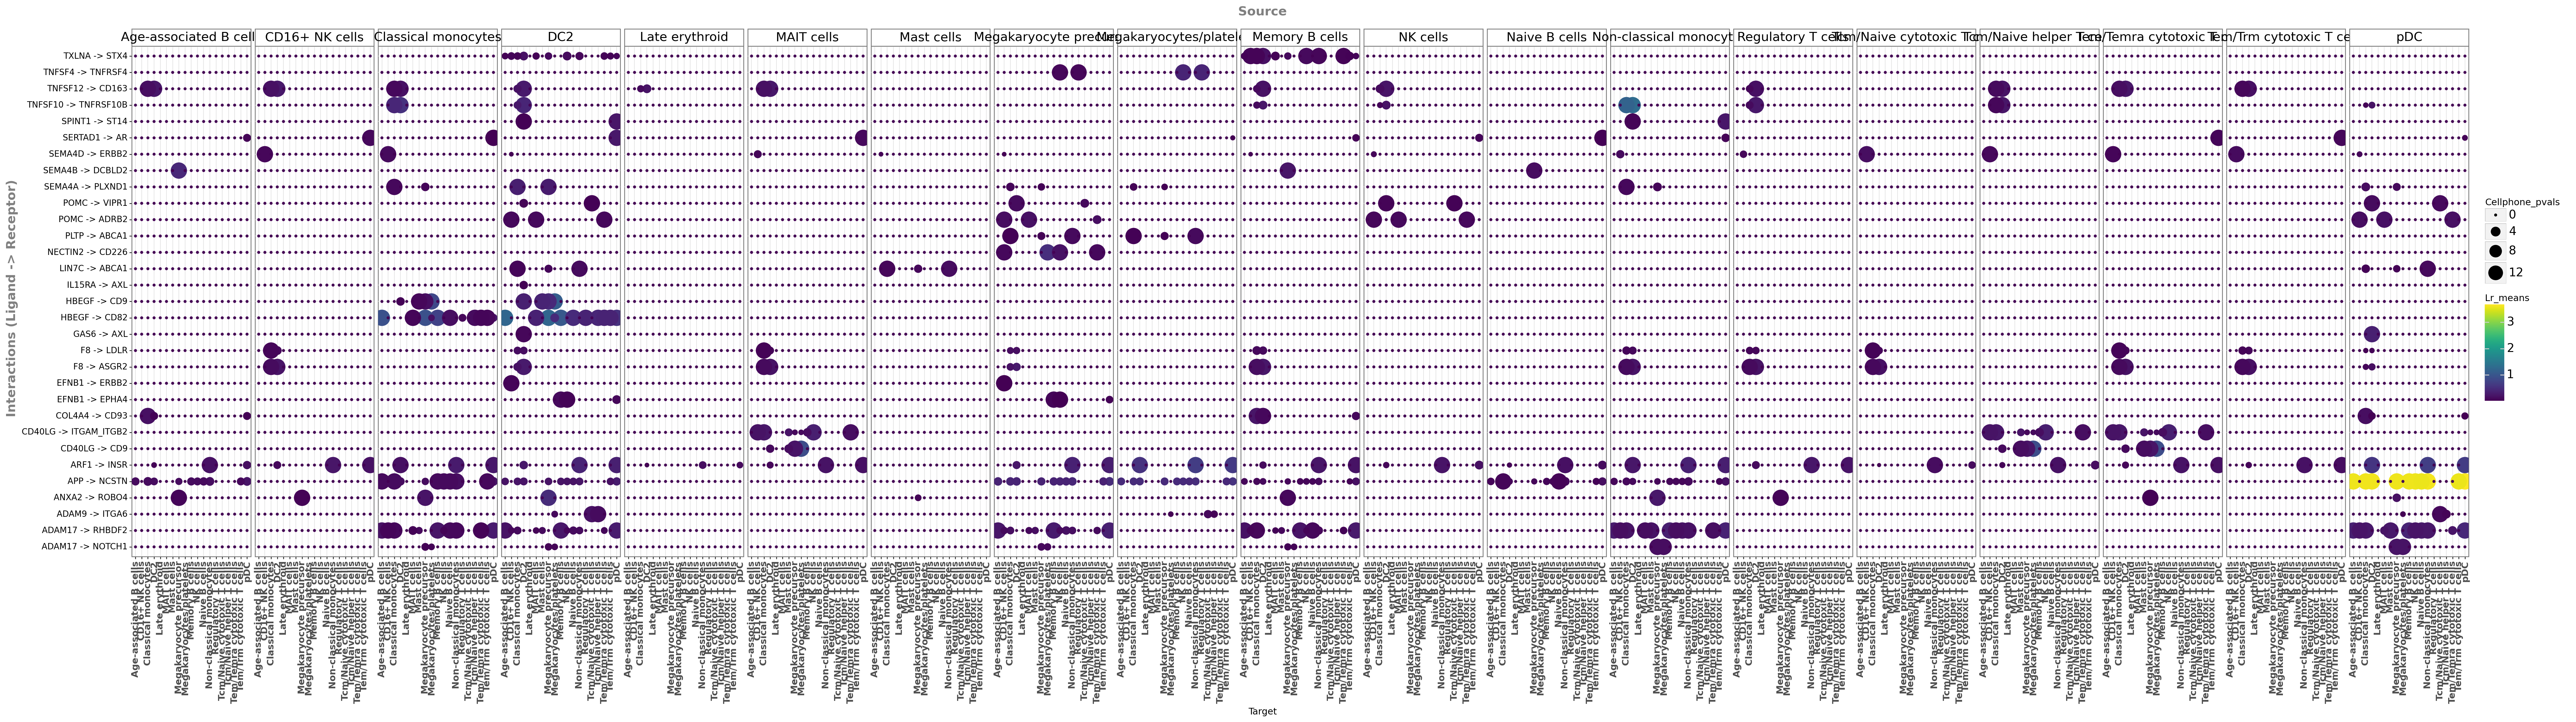

<ggplot: (97513303504)>

In [48]:
# Dotplot with all cell types as source and target
li.pl.dotplot(
    adata=adata_ss,
    colour='lr_means',
    size='cellphone_pvals',
    inverse_size=True,
    source_labels=cell_types_sa,
    target_labels=cell_types_sa,
    ligand_complex=lig_com_sa,
    receptor_complex=rec_comp_sa,
    orderby='lr_means',
    orderby_ascending=False,
    figure_size=(50, 11),
    size_range=(1, 10)
)

In [49]:
table1 = adata_ss_filter_sa['source'].value_counts()
table2 = adata_ss_filter_sa['target'].value_counts()
cells = pd.merge(table1, table2, left_index= True, right_index= True)
cells['Diff'] = cells['source'] - cells['target']
cells.index.name = 'Cell Type'
cells['Cell Type'] = cells.index
cells

source  target  Diff                    Cell Type
Cell Type                                                                     
DC2                            1156     990   166                          DC2
Classical monocytes            1072     884   188          Classical monocytes
Non-classical monocytes        1037    1140  -103      Non-classical monocytes
pDC                             752     779   -27                          pDC
CD16+ NK cells                  696     654    42               CD16+ NK cells
Tem/Temra cytotoxic T cells     590     638   -48  Tem/Temra cytotoxic T cells
Megakaryocyte precursor         585     443   142      Megakaryocyte precursor
MAIT cells                      542     491    51                   MAIT cells
Memory B cells                  526     476    50               Memory B cells
Age-associated B cells          505     395   110       Age-associated B cells
Naive B cells                   352     338    14                Naive B cells
NK cells                        321     428  -107                     NK cells
Tem/Trm cytotoxic T cells       321     478  -157    Tem/Trm cytotoxic T cells
Tcm/Naive cytotoxic T cells     304     357   -53  Tcm/Naive cytotoxic T cells
Regulatory T cells              298     400  -102           Regulatory T cells
Megakaryocytes/platelets        289     367   -78     Megakaryocytes/platelets
Tcm/Naive helper T cells        287     307   -20     Tcm/Naive helper T cells
Late erythroid                  118     124    -6               Late erythroid
Mast cells                       81     143   -62                   Mast cells

In [50]:
# Sort dataframe by source
cells = cells.sort_values('source', ascending=False)
# Sort dataframe by diff
cells2 = cells.sort_values('Diff', ascending=False)

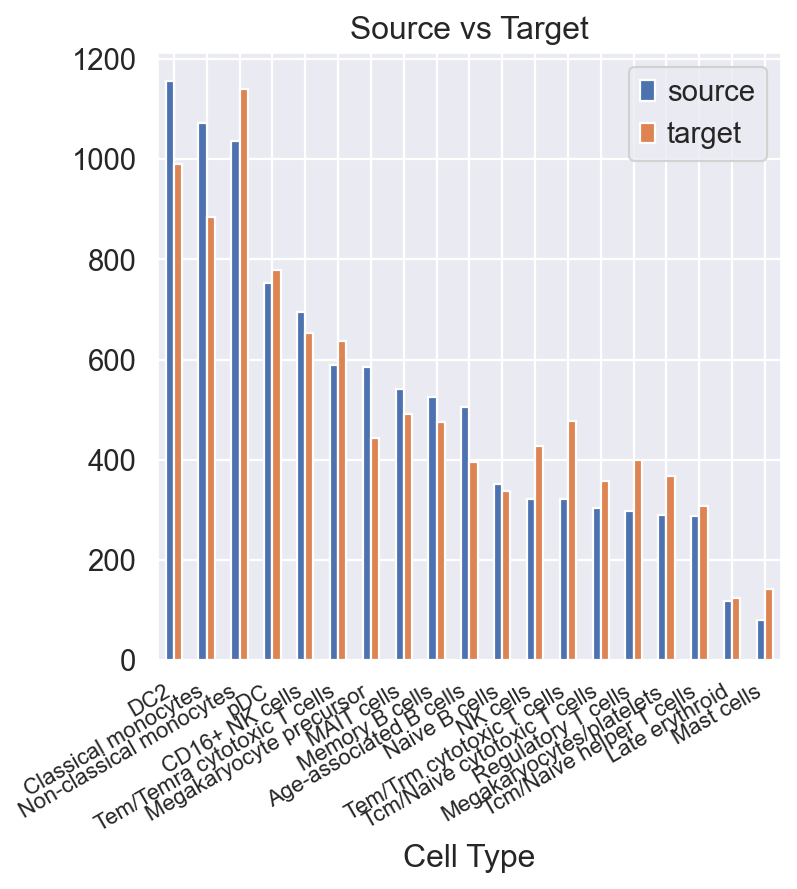

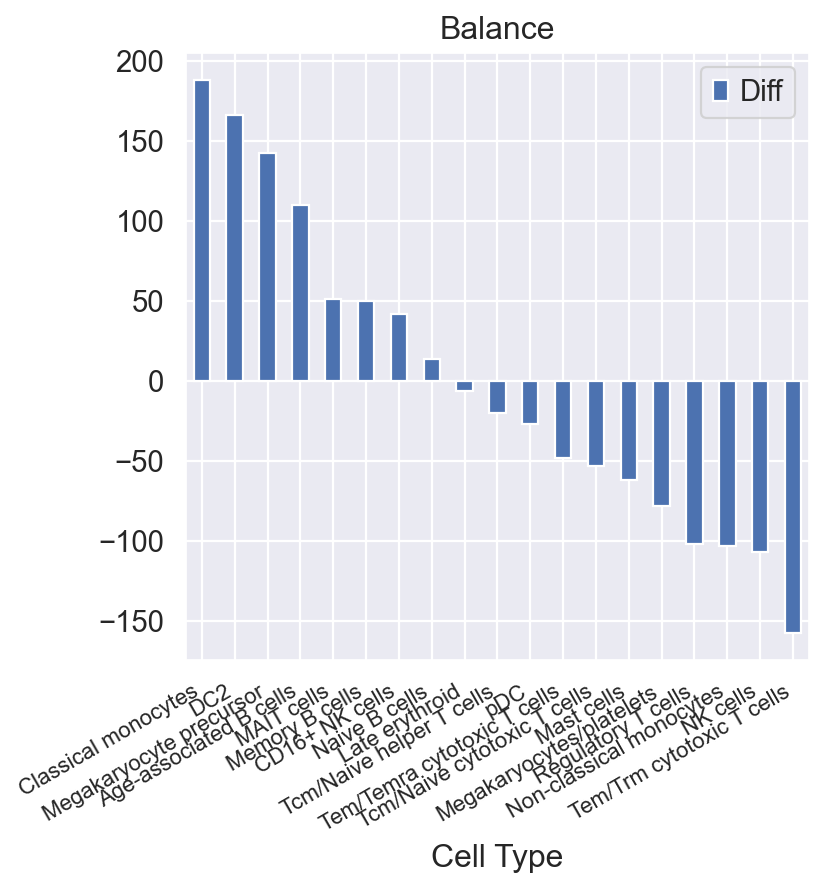

In [51]:
# Plot cell types counts in source and target
cells.plot.bar(x ='Cell Type', y = ['source', 'target'])
plt.title('Source vs Target')
plt.xticks(rotation=30, ha='right', fontsize = 10)
plt.savefig('Final_figs/Source_vs_target.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.3)

# Plot the difference in counts of Source and Target for each cell type
cells2.plot.bar(x = 'Cell Type', y = 'Diff')
plt.title('Balance')
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.savefig('Final_figs/Balance.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.3)

plt.show()

In [52]:
# Get the gene markers
markers_sa = pd.read_table('Markers_SA.csv', sep=' ')
markers_sa.head()

p_val  avg_log2FC  pct.1  pct.2  p_val_adj                      cluster  \
0    0.0    3.273692  0.864  0.102        0.0  Tcm/Naive cytotoxic T cells   
1    0.0    3.108659  0.817  0.120        0.0  Tcm/Naive cytotoxic T cells   
2    0.0    4.232848  0.720  0.059        0.0  Tcm/Naive cytotoxic T cells   
3    0.0    1.491348  0.838  0.187        0.0  Tcm/Naive cytotoxic T cells   
4    0.0    1.948411  0.857  0.229        0.0  Tcm/Naive cytotoxic T cells   

        gene  
0       CD8B  
1      NELL2  
2  LINC02446  
3       CD8A  
4       LEF1

In [53]:
# Table with top ligands expression 
adata_ss_filter_sa = adata_ss_filter_sa.query('interaction in @top_interactions')
mask_sa = markers_sa['gene'].isin(adata_ss_filter_sa['ligand'].unique()[0:30])
markers_filter_sa = markers_sa[mask_sa]
# Matrix with ligands expression by cell type
matrix_sa = markers_filter_sa.pivot(index='gene', columns='cluster', values='avg_log2FC')
matrix_sa.shape

(24, 20)

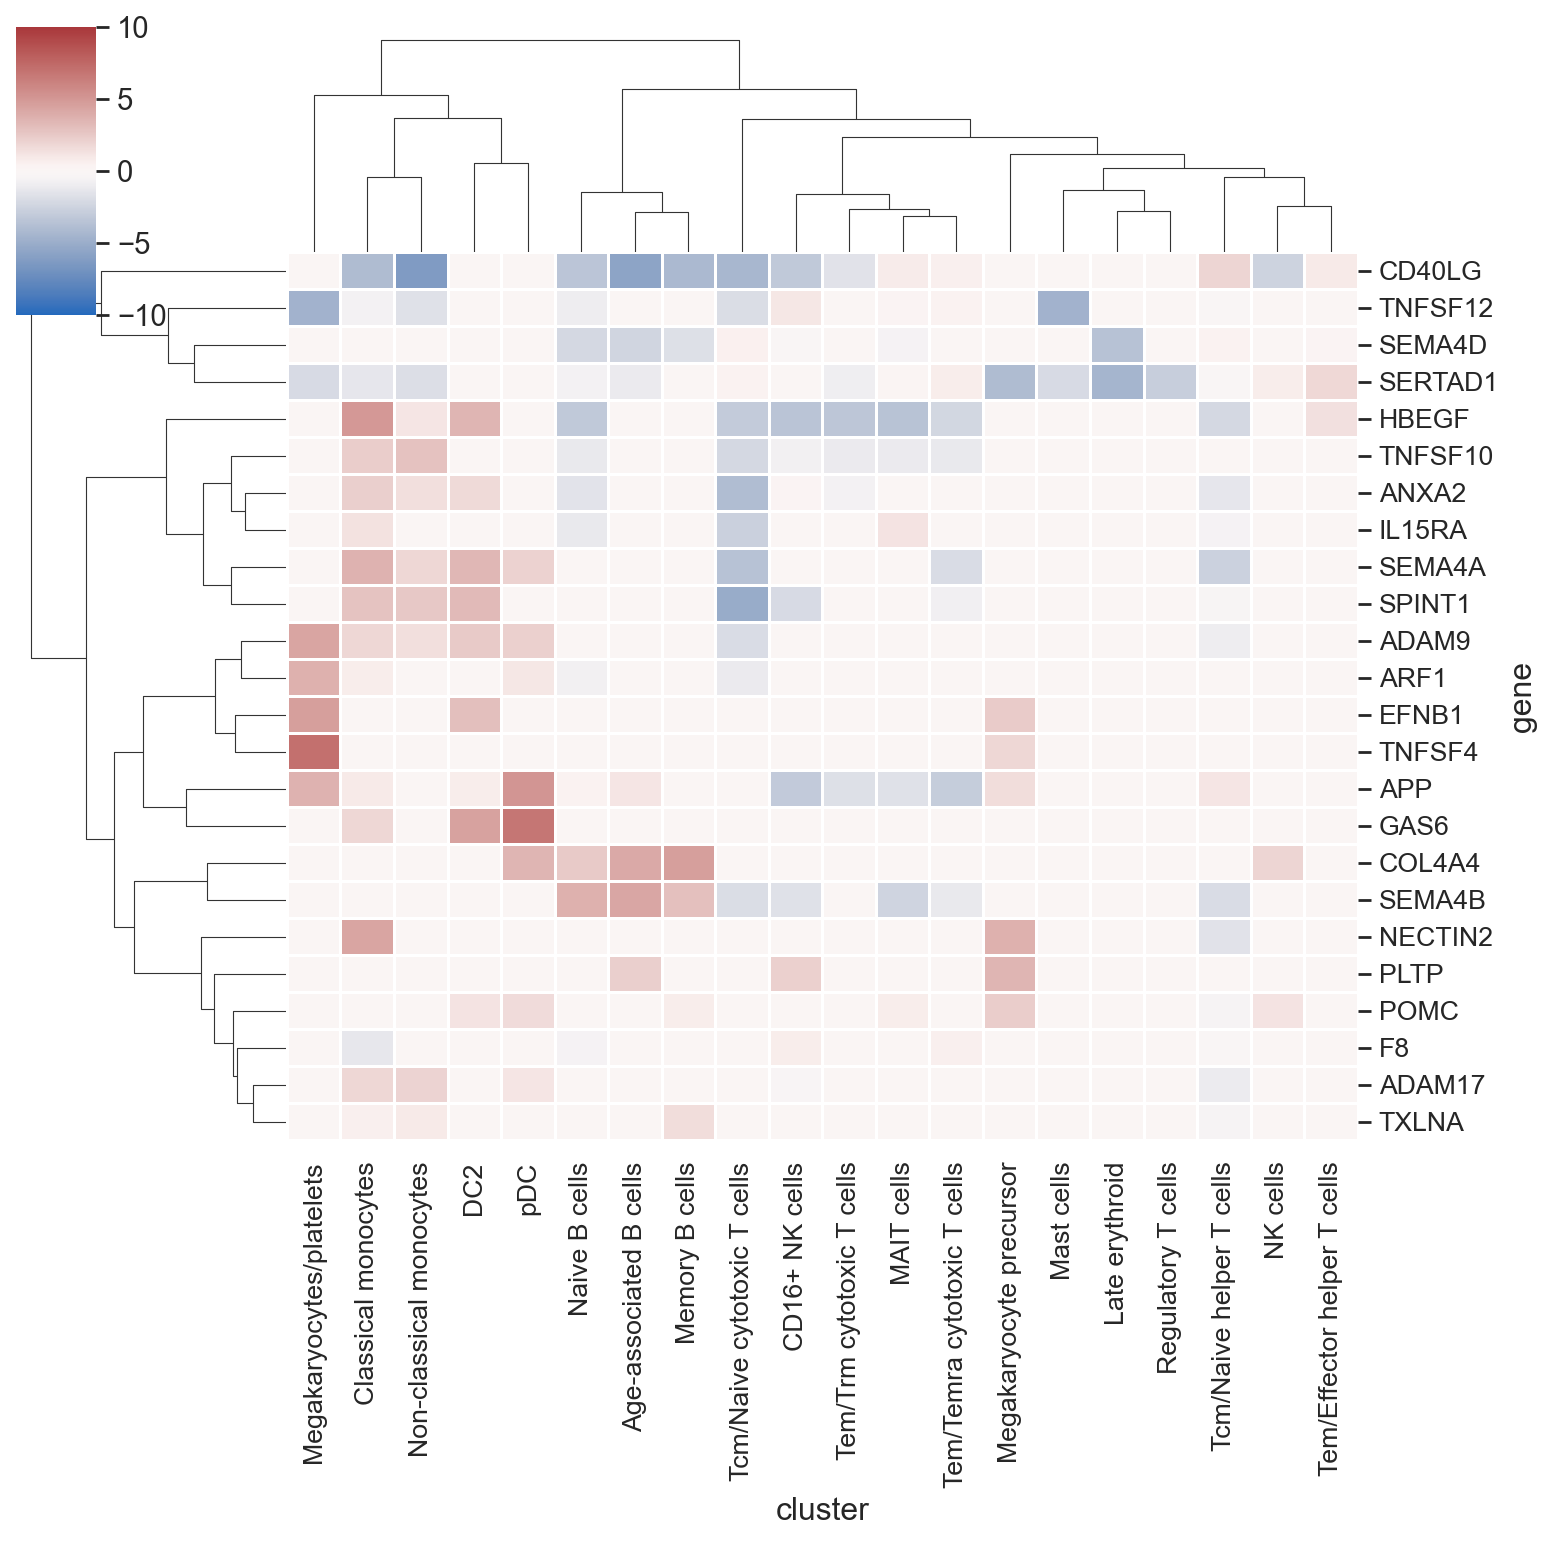

In [54]:
# Clustermap with ligands expression by cell type
sns.set(font_scale=1.2)
clustermap_sa = sns.clustermap(matrix_sa.fillna(0), cmap='vlag', annot=False, linewidths=.5, cbar_kws={"shrink": 0.7}, method="ward", vmax = 10, vmin = -10)
clustermap_sa.ax_heatmap.set_xticklabels(clustermap_sa.ax_heatmap.get_xticklabels(), fontsize=12)
clustermap_sa.ax_heatmap.set_yticklabels(clustermap_sa.ax_heatmap.get_yticklabels(), fontsize=12)

plt.savefig('Final_figs/heatmap_ligands.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.3)

In [55]:
# Top receptors expression
mask_re_sa = markers_sa['gene'].isin(adata_ss_filter_sa['receptor'].unique()[0:30])
markers_filter_re_sa = markers_sa[mask_re_sa]

matrix_re_sa = markers_filter_re_sa.pivot(index='gene', columns='cluster', values='avg_log2FC')
matrix_re_sa.shape

(27, 19)

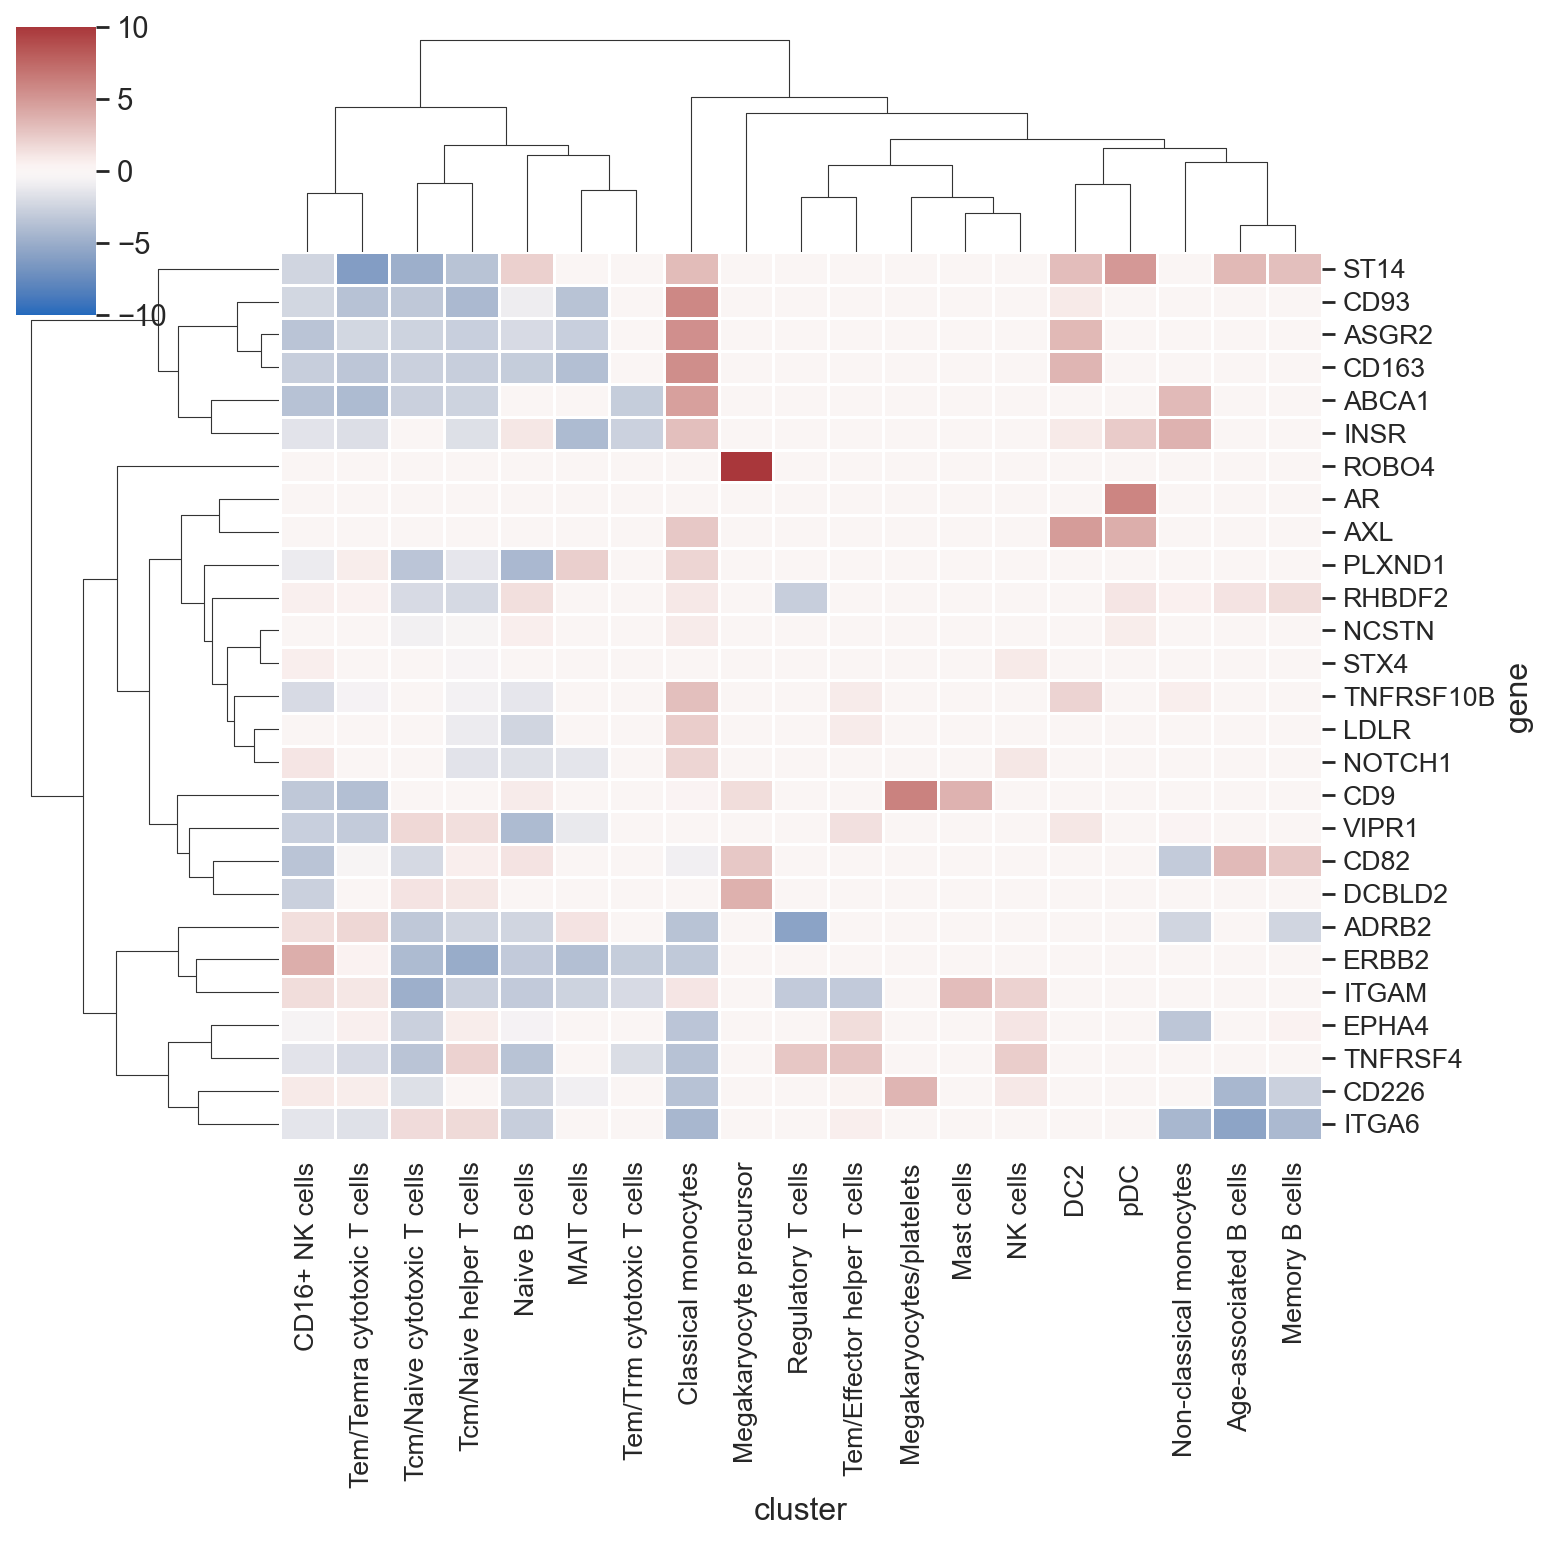

In [56]:
# Clustermap with top receptors expression by cell type
sns.set(font_scale=1.2)
clustermap_re_sa = sns.clustermap(matrix_re_sa.fillna(0), cmap='vlag', annot=False, linewidths=.5, cbar_kws={"shrink": 0.7}, method = 'ward', vmax = 10, vmin = -10)
clustermap_re_sa.ax_heatmap.set_xticklabels(clustermap_re_sa.ax_heatmap.get_xticklabels(), fontsize=12)
clustermap_re_sa.ax_heatmap.set_yticklabels(clustermap_re_sa.ax_heatmap.get_yticklabels(), fontsize=12)
plt.savefig('Final_figs/heatmap_receptors.png', dpi = 100, bbox_inches = 'tight', pad_inches = 0.3)

In [57]:
# Define cell types in source and target 
types = ['Classical monocytes', 'Non-classical monocytes', 'Naive B cells', 'Age-associated B cells', 'Memory B cells', 'DC2', 'pDC']

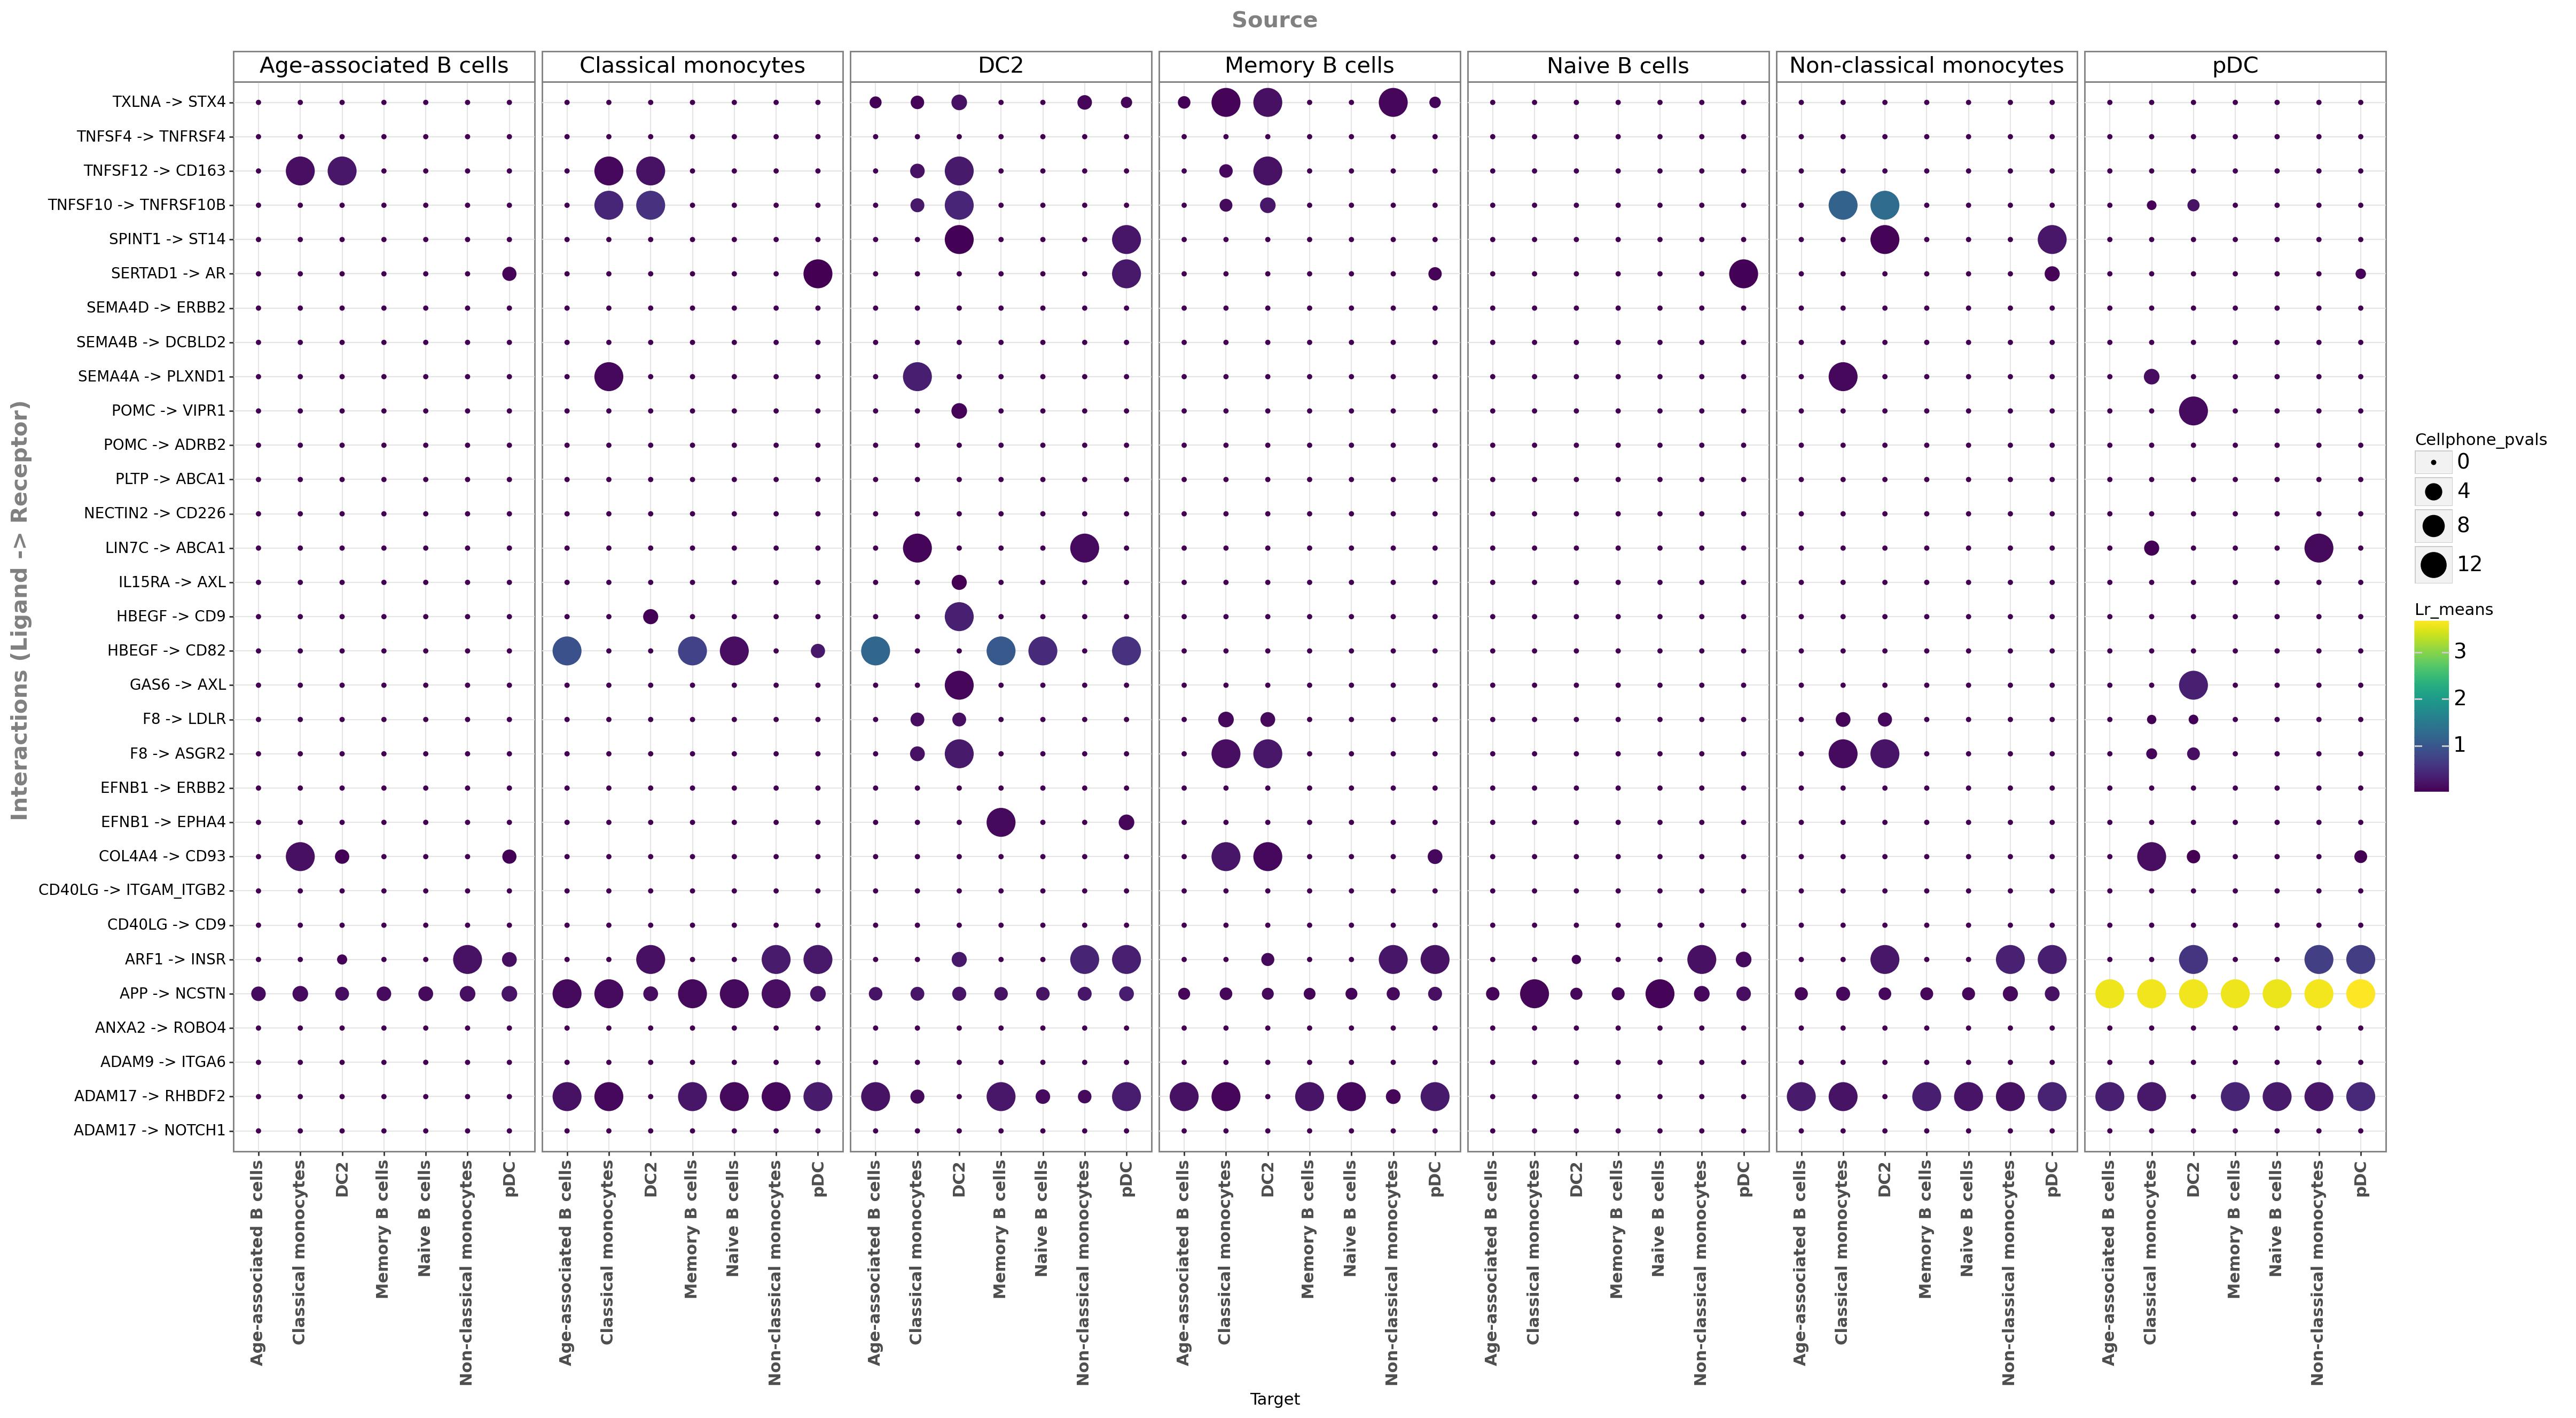

<ggplot: (97560895967)>

In [59]:
# Final dotplot with cell types defined as source and target
dotplot = li.pl.dotplot(
    adata=adata_ss,
    colour='lr_means',
    size='cellphone_pvals',
    inverse_size=True,
    source_labels= types,
    target_labels= types,
    ligand_complex=lig_com_sa,
    receptor_complex=rec_comp_sa,
    figure_size=(26, 13),
    size_range=(1, 10), 
)


dotplot